In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from scipy import signal
from functools import reduce
from collections import defaultdict
import pprint
from tqdm.notebook import tqdm
import pandas as pd # Only here to print arrays nicely

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# TOC
1. [1x1 Beam Functions](#1x1)
2. [NxN Beam Complications](#NxN)
3. [Playground](#playground)

### Simplified case for 1x1 beam <a name="1x1"></a>

In [281]:
def get_num_baselines(Nside):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated Qare the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*Nside**2 - 2*Nside
    return int(N_bases)

rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)
zero_weight = lambda x, d: x/d if d else 0
vector_weights = np.vectorize(zero_weight)
parray = lambda x: np.round(x, decimals=2)

def make_gains(Nside):
    # Create complex gains with either (amplitude, phase) or (real, imaginary)
    Nant = Nside**2
    gain_amp = np.random.normal(1, .05, Nant)
    gain_phase = rand_phases(Nant)
    tgain = gain_amp*np.exp(1j*gain_phase)    
    return tgain

def make_data(Nside, gains, noise=0.1):
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    vis_true = np.random.normal(0,1,size=(Nbase,2)).view(np.complex128).flatten() ## size of unique baselines
    ant_i, ant_j, visndx, data = [], [], [], []
    ndx=0
    ndx2base={}
    base2ndx={}
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside,Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside,Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in base2ndx:
                cndx = base2ndx[baseline]
            else:
                cndx = ndx
                base2ndx[baseline]=ndx
                ndx2base[ndx]=baseline
                ndx+=1
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(cndx)
            data.append(vis_true[cndx]*gains[i]*np.conj(gains[j]))
            
    assert(ndx==Nbase)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx

In [4]:
def make_pred(gains, vis, ant_i, ant_j, visndx):
    gains_i = gains[ant_i]
    cgains_j = np.conj(gains[ant_j])
    pred = gains_i*cgains_j*vis[visndx]
    return pred

In [5]:
def chi2(data, gains, vis, ant_i, ant_j, visndx, noise=0.1):
    pred = make_pred(gains, vis, ant_i, ant_j, visndx)
    chi2 = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chi2, dof

### NxN beam complications <a name="NxN"></a>

In [661]:
def get_weighted_array(alpha, Nspacing, numdraws=1e5):
    # Overlap a circular beam onto a pixelized grid 
    Nbeam = Nspacing**2
    rmax = alpha*.5
    ndraws = int(numdraws)
    spacing = np.linspace(0,1,Nspacing+1)
    centered_spacing = spacing - .5
    empty_weight_beam = np.zeros((Nspacing, Nspacing), dtype=np.complex128)
    
    for i in range(Nbeam):
        xi, yi = np.unravel_index(i, (Nspacing, Nspacing))
        draws = np.array([np.random.uniform(centered_spacing[xi], centered_spacing[xi+1], ndraws), np.random.uniform(centered_spacing[yi], centered_spacing[yi+1], ndraws)])
        dist = np.linalg.norm(draws, axis=0)
        empty_weight_beam[xi, yi] = np.sum(dist < rmax)/ndraws #* np.exp(1j*rand_phases(1))
    sym_beam = .5*(empty_weight_beam + empty_weight_beam.T)
    return sym_beam

In [662]:
# Helper function to get a (2*br-1, 2*br-1) grid around point x

def n_mesh(br):
    nmesh = lambda x: tuple(np.meshgrid(range(x[0]-br, x[0]+br+1), range(x[1]-br, x[1]+br+1), indexing='ij'))
    return nmesh

five_mesh = n_mesh(2)

In [8]:
def make_uv_grid(Nside):
    uv_size = Nside*2 - 1
    center = (Nside-1,Nside-1)
    npcenter = np.array(center)
    img_size = (uv_size, uv_size)
    random_image = np.random.normal(0, 1, img_size)
    centered_uv = np.fft.fftshift(np.fft.fft2(random_image))
#     centered_uv[center] = 0
    topleft_uv = np.fft.ifftshift(centered_uv)
    
    return centered_uv, topleft_uv, npcenter

In [616]:
def get_new_shape(Nside, beam_radius=3):
    # Helper function
    orig_shape = (2*Nside-1, Nside)
    new_shape = tuple([i*beam_radius + (beam_radius - 1) for i in orig_shape])
    return new_shape

In [663]:
def make_visibilities(Nside, beam_radius):
    n = Nside
    br = beam_radius
    
    # Useful shapes/sizes to have on hand
    new_shape = get_new_shape(n, br)
    new_size = np.prod(new_shape)
    center = (int((new_shape[0]-1)/2), br-1)
    
    #Matrices of visibiltiies and possible indices
    random_vis = np.random.normal(0, 1, (new_shape[0], new_shape[1], 2)).view(np.complex128)
    poss_index = np.arange(new_size).reshape(new_shape)
    
    #Clear off the leftmost columns to remove redundant conjugate stuff
    poss_index[0:center[0], 0:br] = 0
    poss_index[center[0]:, 0:br-1] = 0
    
    oversampled_baselines = poss_index.nonzero()[0].shape[0]
    visib = np.zeros(oversampled_baselines, dtype=np.complex128)
    #Baseline - index dictionaries
    new_ndx = 0
    n2b = {}
    b2n = {}
    n2true = {}
    true2n = {}
    for i in range(new_size):
        xi,yi = np.unravel_index(i, new_shape)
        if poss_index[xi,yi] == 0:
            continue
        else:
            baseline = (xi-center[0], yi-center[1])
            if baseline[0] < 0:
                baseline = (-1*baseline[0], -1*baseline[1])

            if baseline in b2n:
                cndx = new_ndx
            else:
                cndx = new_ndx
                b2n[baseline] = new_ndx
                n2b[new_ndx] = baseline
                if tuple(np.mod(baseline, br)) == (0,0):
                    modtuple = tuple(np.floor_divide(baseline, 3))
                    true2n[modtuple] = new_ndx
                    n2true[new_ndx] = modtuple
                new_ndx += 1
        visib[cndx] = random_vis[xi,yi]
    return n2b, b2n, n2true, true2n, visib

In [10]:
def vis_to_grid(visib, ndx2base, size):
    # Turn our flat list of visibilities into a grid based on the dictionary
    # Meshes make properly yanking data from a grid straight-forward and also takes into account proper
    # negative indexing which makes it preferable to the flat visibility list.
    
    # Double the size to make sure to avoid rewriting values with negative indexing
    uv_size = (2*size[0], 2*size[1])
    new_grid = np.zeros(uv_size, dtype=np.complex128)
    for i,v in enumerate(visib):
        base = ndx2base[i]
        inv_base = tuple(-1*np.array(base))
        new_grid[base] = v
        new_grid[inv_base] = np.conj(v)
    return new_grid

In [614]:
def make_data_grid(Nside, gains, beams, noise=0.1, verbose=True):
    
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    # Get sample beam to understand shape of convolved beams
    samp_beam = signal.convolve(beams[0], beams[0])
    
    #Radius and corresponding mesh
    beam_radius = int((samp_beam.shape[0]-1)/2) + 1
    mesh = n_mesh(beam_radius-1)
    
    # Create visibilities
    n2b, b2n, n2t, t2n, visib = make_visibilities(Nside, beam_radius)
    if verbose:
        print("Made visib")
    
    new_shape = get_new_shape(Nside, beam_radius)
    vis_grid = vis_to_grid(visib, n2b, new_shape)
    if verbose:
        print("Made grid")
    
    ant_i, ant_j, visndx, data, datandx = [], [], [], [], []
    
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            conv_beam = signal.convolve(beams[i], np.conj(beams[j]))
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            
            virtual_n = t2n[baseline]
            grid_base = n2b[virtual_n]
            
            virtual_points = mesh(grid_base)
            data_sum = (vis_grid[virtual_points] * gains[i] * np.conj(gains[j]) * conv_beam).sum()
            
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(virtual_n)
            data.append(data_sum)
            datandx.append(virtual_points)
    
    if verbose:
        print("Created data")
    
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return visib, data, ant_i, ant_j, visndx, datandx, n2b, b2n, n2t, t2n, vis_grid

In [664]:
def vector_b2n(b2n, datandx):
    # Convert datandx (points on the grid) to flat indices using b2n dictionary
    newndx = []
    for l in datandx:
        x,y = l
        flattened = []
        ndx_size = x.size
        ndx_shape = x.shape
        for i in range(ndx_size):
            point = np.unravel_index(i, ndx_shape)
            k = np.array([x[point], y[point]])
            key = tuple(k)
            if key in b2n:
                flattened.append(b2n[key])
            else:
                key = tuple(-1*k)
                flattened.append(-1*b2n[key])
        newndx.append(flattened)
    newndx = np.array(newndx)
    return newndx

In [665]:
def conjugate_visib(vis, ndxs):
    # Returns the proper list of relevant visibilites given ndxs
    # Negative refers to using a conjugate rather than doubling the size of the array
    flat = []
    for i in ndxs:
        if i >= 0:
            flat.append(vis[i])
        else:
            flat.append(np.conj(vis[-1*i]))
    return np.array(flat)

In [666]:
def flat_model(vis, gains, beams, ant_i, ant_j, flatndx):
    # Make prediction
    postage = np.array([signal.convolve(beams[ant_i[i]], np.conjugate(beams[ant_j[i]])).flatten() for i in range(len(flatndx))])
    gains_i = gains[ant_i]
    gains_j = np.conj(gains[ant_j])
    flatbread = np.array([conjugate_visib(vis, v)*postage[i] for i, v in enumerate(flatndx)])
    pred = np.sum(flatbread, axis=1)*gains_i*gains_j
    return pred

In [667]:
def gen_chi2(data, pred, noise=0.1):
    # Generic chi2 definition
    chi2 = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chi2, dof, chi2/dof

In [668]:
def imag_to_reals(vec):
    # Helper function for linear estimator
    reals = vec.real
    imags = vec.imag
    flat_vec = np.concatenate((reals, imags))
    return flat_vec

In [707]:
def linear_solver_A(data, fndx, beams, ant_i, ant_j):
    # Solve for visibilities using a linear method
    big_ans = imag_to_reals(data)
    data_len = len(data)
    v_size = len(set(np.abs(fndx).flatten())) + 1
    postage = np.array([signal.convolve(beams[ant_i[i]], np.conjugate(beams[ant_j[i]])).flatten() for i in range(len(fndx))])
    bigA = sparse.lil_matrix((2*data_len, 2*v_size))
    for i,v in enumerate(flatndx):
        absv = np.abs(v)
        bigA[i,absv] = postage[i].real
        bigA[i, v_size+absv] = -1*np.sign(v)*postage[i].imag
        bigA[i+data_len, absv] = np.sign(v)*postage[i].imag
        bigA[i+data_len, v_size+absv] = postage[i].real
    bigCSR = bigA.tocsr()
    return bigCSR, big_ans

In [669]:
Nside = 15
Nant = Nside * Nside
Nbase = get_num_baselines(Nside)
# gains_true = make_gains(Nside)
gains_true = np.ones(Nant, dtype=np.complex128)
# vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx = make_data(Nsmide, gains_true)
weighted_beam = get_weighted_array(1, 3)
beams = np.array([weighted_beam*np.exp(1j*rand_phases(1)) for i in range(Nant)])
vis_true, data, ant_i, ant_j, visndx, datandx, n2b, b2n, n2t, t2n, tl_grid = make_data_grid(Nside, gains_true, beams, noise=0.1)
flatndx = vector_b2n(b2n, datandx)
data_len = len(data)

Made visib
Made grid
Created data


In [618]:
flatbread = flat_model(vis_true, gains_true, beams, ant_i, ant_j, flatndx)

In [619]:
print("Flat solution ", gen_chi2(data, flatbread))

Flat solution  (50481.00287299071, 50400, 1.0016071998609268)


In [672]:
bigA, bigB = linear_solver_A(data, flatndx, beams, ant_i, ant_j) 

In [687]:
# Wiener map making method
Sinv_dia = sparse.dia_matrix((np.ones(vec_shape), 0), (vec_shape, vec_shape))
Sinv = Sinv_dia.tocsr()

Ninv_dia = sparse.dia_matrix((np.ones(big_shape)*100, 0), (big_shape, big_shape))
Ninv = Ninv_dia.tocsr()

lhsX = Sinv + bigA.T@Ninv@bigA
rhsY = bigA.T@Ninv@bigB

In [708]:
map_sol = sparse.linalg.lsqr(bigA, bigB, atol=1e-6)[0]    # Directly solve for map
# map_sol = sparse.linalg.lsqr(lhsX, rhsY, atol=1e-6)[0]    # Use Wiener filter

In [709]:
comb_sol = map_sol[:v_size] + 1j*map_sol[v_size:]
comb_model = flat_model(comb_sol, gains_true, beams, ant_i, ant_j, flatndx)
gen_chi2(data, comb_model)

(49955.68864045185, 50400, 0.9911842984216638)

### Below this is my random testing/playground <a name="playground"></a>
I have my chi2 minimization algorithm underneath but it doesn't work well at all

In [641]:
# bad_guess = np.random.normal(0,1,(v_size,2)).view(dtype=np.complex128).flatten()
bad_guess = vis_true.copy()
bad_sol = flat_model(bad_guess, gains_true, beams, ant_i, ant_j, flatndx)
gen_chi2(data, bad_sol)

(50481.00287299071, 50400, 1.0016071998609268)

In [642]:
worthy = np.array(list(n2t.keys()))

In [643]:
weights_visib = np.zeros_like(bad_guess, dtype=np.complex128)
gener_v = np.zeros_like(bad_guess, dtype=np.complex128)
zerondx = b2n[(0,0)]

In [644]:
for w in worthy:
    if w==zerondx:
        continue
    vis_filter = (visndx==w)

    postage = np.array([signal.convolve(beams[ant_i[vis_filter][i]], np.conjugate(beams[ant_j[vis_filter][i]])).flatten() for i in range(np.sum(vis_filter))])

    gain_factor = gains_true[ant_i[vis_filter]]*np.conj(gains_true[ant_j[vis_filter]])
    postage_gain = postage*gain_factor[:,None]
    numer = np.sum(data[vis_filter][:,None]*np.conjugate(postage_gain), axis=0)
    denom = np.sum(np.abs(postage_gain)**2, axis=0)

    delta_v = numer/(25*denom)
    gener_v[flatndx[vis_filter][0]] += delta_v
    weights_visib[flatndx[vis_filter][0]] += 1

In [645]:
avged_guess = vector_weights(gener_v, weights_visib)

In [646]:
bad_sol = flat_model(avged_guess, gains_true, beams, ant_i, ant_j, flatndx)
gen_chi2(data, bad_sol)

(398088987.88222575, 50400, 7898.591029409241)

Essentially, it puts ends up putting values such that after convolution each pixel in the 5x5 is the same (the data/25).
But where there is overlap between the data points, averaging just makes it bad at both measurements which leads to the horrible chi2.

In [710]:
v_size = len(set(np.abs(flatndx).flatten())) + 1

In [700]:
bigCSR, bigB = linear_solver_A(data, flatndx, beams, ant_i, ant_j)

In [701]:
map_sol = sparse.linalg.lsqr(bigCSR, bigB, atol=1e-3)[0]

In [702]:
comb_sol = map_sol[:v_size] + 1j*map_sol[v_size:]

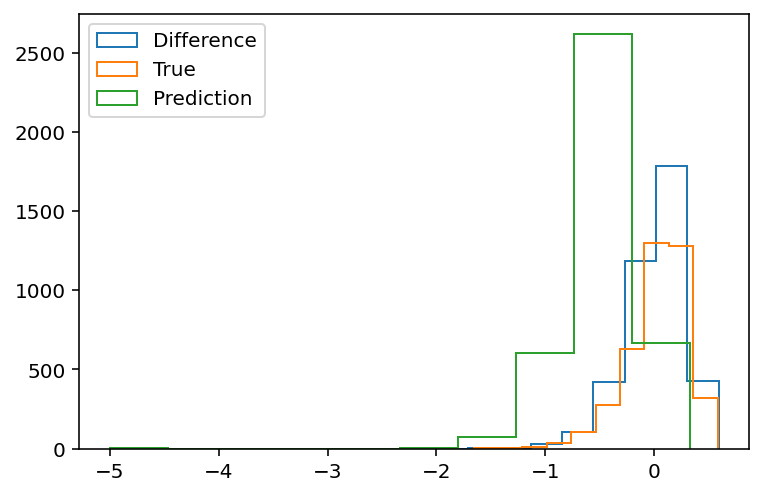

In [703]:
plt.hist(np.log10(np.abs(comb_sol - vis_true) + 1e-5), histtype='step', label='Difference');
plt.hist(np.log10(np.abs(vis_true) + 1e-5), histtype='step', label='True');
plt.hist(np.log10(np.abs(comb_sol) + 1e-5), histtype='step', label='Prediction');
plt.legend(loc='upper left');

In [704]:
comb_model = flat_model(comb_sol, gains_true, beams, ant_i, ant_j, flatndx)

In [705]:
gen_chi2(data, comb_model)

(55149.88370110746, 50400, 1.0942437242283225)